In [1]:
#===========================================================================================
# ALBERT Futher-PreTraining 예시
# => MLM(Masked Language Model)만으로 Further Pre-Train 시키는 예시
# => AlbertForMaskedLM 이용
#===========================================================================================

import torch
from transformers import AlbertTokenizer, AlbertForMaskedLM, AlbertModel
from tqdm.notebook import tqdm
from transformers import AdamW, get_linear_schedule_with_warmup
from os import sys
sys.path.append('..')
from myutils import GPU_info, seed_everything, mlogging, AccuracyForMaskedToken, SaveBERTModel

device = GPU_info()
print(device)

#seed 설정
seed_everything(222)

#logging 설정
logger =  mlogging(loggername="Albertfpt", logfilename="../../log/Albertfpt")


logfilepath:../../log/bwdataset_2022-06-07.log
logfilepath:../../log/qnadataset_2022-06-07.log
True
device: cuda:0
cuda index: 0
gpu 개수: 1
graphic name: NVIDIA A30
cuda:0
logfilepath:../../log/Albertfpt_2022-06-07.log


In [2]:
# 신규 모델에 파일을 불러옴


vocab_path = '../../data11/model/bert/albert-base-v2/newvocab' # 앞에서 만들어진 spiece_new.model 이 있는 경로 지정해줌
model_path = '../../data11/model/bert/albert-base-v2'

tokenizer = AlbertTokenizer.from_pretrained(vocab_path)
print(len(tokenizer))

model = AlbertForMaskedLM.from_pretrained(model_path)

# resize_token_embeddings 으로 신규 tokenizer 사이즈로 지정 해줌.
model.resize_token_embeddings(len(tokenizer))
model.to(device)

Some weights of AlbertForMaskedLM were not initialized from the model checkpoint at ../../data11/model/bert/albert-base-v2 and are newly initialized: ['predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


54152


AlbertForMaskedLM(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(54152, 128)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (

In [3]:
model.num_parameters()

14337288

In [4]:
# text tokenizer 해봄.
text = "모코엠시스에서는 문서중앙화 및 보안파일서버 솔루션인 엠파워를 출시하였다."
token_ids = tokenizer.encode_plus(text, max_length=128, padding="max_length", return_tensors="pt")
print(token_ids)

{'input_ids': tensor([[    2, 54150,     1, 54146, 30010, 54147, 30219,     1, 54148,     1,
         31858,     1,     9,     3,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [5]:
# 각 스페셜 tokenid를 구함
CLStokenid = tokenizer.convert_tokens_to_ids('[CLS]')
SEPtokenid = tokenizer.convert_tokens_to_ids('[SEP]')
UNKtokenid = tokenizer.convert_tokens_to_ids('<UNK>')
PADtokenid = tokenizer.convert_tokens_to_ids('<pad>')
MASKtokenid = tokenizer.convert_tokens_to_ids('[MASK]')

print(CLStokenid)
print(SEPtokenid)
print(UNKtokenid)
print(PADtokenid)
print(MASKtokenid)


2
3
1
0
4


In [6]:
input_corpus = '../../data11/korpora/nlp_corpus_merge.txt'
eval_corpus = '../../data11/korpora/kowiki_20190620/wiki_eval_test.txt'
token_max_len = 128
batch_size = 32
#==============================================================================
# DataLoader 설정으로 메모리 속도 계선방법
#
# 1) num_workers>0 설정
# num_workers=0훈련 또는 이전 프로세스가 완료된 후에만 데이터 로드를 실행하는 반면,
# num_workers > 0 값으로 설정하면 특히 I/O 및 대용량 데이터 증가에 대한 프로세스가 가속된다
# => 따라서 Dataloader(dataset, num_workers=4*num_GPU) 식으로 설정함
#
# 2) pin_memory=True 설정
# GPU는 CPU의 페이징 가능한 메모리에서 직접 데이터에 액세스할 수 없습니다. 
# 이 설정 pin_memory=True은 CPU 호스트의 데이터에 대한 스테이징 메모리를 직접 할당하고 
# 페이징 가능 메모리에서 스테이징 메모리(즉, 고정된 메모리, 페이지 잠금 메모리)로 데이터를 
# 전송하는 시간을 절약할 수 있다.
# => Dataloader(dataset, pin_memory=True)
#=========================================================================


from torch.utils.data import DataLoader, RandomSampler
import sys
sys.path.append('..')
from myutils import MLMDataset

# 각 스페셜 tokenid를 구함
CLStokenid = tokenizer.convert_tokens_to_ids('[CLS]')
SEPtokenid = tokenizer.convert_tokens_to_ids('[SEP]')
UNKtokenid = tokenizer.convert_tokens_to_ids('<UNK>')
PADtokenid = tokenizer.convert_tokens_to_ids('<pad>')
MASKtokenid = tokenizer.convert_tokens_to_ids('[MASK]')
print('CLSid:{}, SEPid:{}, UNKid:{}, PADid:{}, MASKid:{}'.format(CLStokenid, SEPtokenid, UNKtokenid, PADtokenid, MASKtokenid))


train_dataset = MLMDataset(corpus_path = input_corpus,
                           tokenizer = tokenizer, 
                           CLStokeinid = CLStokenid ,   # [CLS] 토큰 id
                           SEPtokenid = SEPtokenid ,    # [SEP] 토큰 id
                           UNKtokenid = UNKtokenid ,    # [UNK] 토큰 id
                           PADtokenid = PADtokenid,    # [PAD] 토큰 id
                           Masktokenid = MASKtokenid,   # [MASK] 토큰 id
                           max_sequence_len=token_max_len,  # max_sequence_len)
                           mlm_probability=0.15,
                           overwrite_cache=False
                          )


# 학습 dataloader 생성
# => tenosor로 만듬
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          #shuffle=True, # dataset을 섞음
                          sampler=RandomSampler(train_dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                          num_workers=4,   # *num_workers = 4*num_GPU 로 설정(프로세스가 빨라짐)
                          pin_memory=True  # *pin_memory=True은 페이징 가능 메모리에서 스테이징 메모리로 전송하는 시간을 줄여줌
                         )

#===============================================================================
# eval dataloader 생성
eval_dataset = MLMDataset(corpus_path = eval_corpus,
                          tokenizer = tokenizer, 
                          CLStokeinid = CLStokenid ,   # [CLS] 토큰 id
                          SEPtokenid = SEPtokenid ,    # [SEP] 토큰 id
                          UNKtokenid = UNKtokenid ,    # [UNK] 토큰 id
                          PADtokenid = PADtokenid,    # [PAD] 토큰 id
                          Masktokenid = MASKtokenid,   # [MASK] 토큰 id
                          max_sequence_len=token_max_len,  # max_sequence_len)
                          mlm_probability=0.15,
                          overwrite_cache=False
                          )


# eval dataloader 생성
# => tenosor로 만듬
eval_loader = DataLoader(eval_dataset, 
                         batch_size=batch_size, 
                         #shuffle=True, # dataset을 섞음
                         sampler=RandomSampler(eval_dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                         num_workers=4,   # *num_workers = 4*num_GPU 로 설정(프로세스가 빨라짐)
                         pin_memory=True  # *pin_memory=True은 페이징 가능 메모리에서 스테이징 메모리로 전송하는 시간을 줄여줌
                         )
#===============================================================================

print(train_dataset[0])

CLSid:2, SEPid:3, UNKid:1, PADid:0, MASKid:4
*corpus:../../data11/korpora/nlp_corpus_merge.txt
*max_sequence_len:128
*mlm_probability:0.15
*CLStokenid:2, SEPtokenid:3, UNKtokenid:1, PADtokeinid:0, Masktokeid:4
*total_line: 580110


  0%|          | 0/580110 [00:00<?, ?it/s]

  0%|          | 0/580110 [00:00<?, ?it/s]

2022-06-07 15:23:41,337 - bwpdataset - INFO - ==>[Start] cached file create: ../../data11/korpora/cached_lm_AlbertTokenizer_128_nlp_corpus_merge.txt
2022-06-07 15:23:48,205 - bwpdataset - INFO - <==[End] Saving features into cached file ../../data11/korpora/cached_lm_AlbertTokenizer_128_nlp_corpus_merge.txt [took 6.867 s]


*corpus:../../data11/korpora/kowiki_20190620/wiki_eval_test.txt
*max_sequence_len:128
*mlm_probability:0.15
*CLStokenid:2, SEPtokenid:3, UNKtokenid:1, PADtokeinid:0, Masktokeid:4
*total_line: 114


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

2022-06-07 15:23:48,383 - bwpdataset - INFO - ==>[Start] cached file create: ../../data11/korpora/kowiki_20190620/cached_lm_AlbertTokenizer_128_wiki_eval_test.txt
2022-06-07 15:23:48,385 - bwpdataset - INFO - <==[End] Saving features into cached file ../../data11/korpora/kowiki_20190620/cached_lm_AlbertTokenizer_128_wiki_eval_test.txt [took 0.002 s]


{'input_ids': tensor([    2, 38231,     4,     4,    14,   566,  4403, 10724,     1,  4943,
           38,  1418,    26,    85,  3208,     4,     4, 32795,    26,     4,
         3078,    45,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

In [9]:
##################################################
epochs = 5            # epochs
learning_rate = 3e-5  # 학습률
OUTPATH = '../../data11/model/bert/albert-base-v2/albert-base-v2-ftp'
##################################################

# optimizer 적용
optimizer = AdamW(model.parameters(), 
                 lr=learning_rate, 
                 eps=1e-8) # 0으로 나누는 것을 방지하기 위한 epsilon 값(10^-6 ~ 10^-8 사이 이값 입력합)

# 총 훈련과정에서 반복할 스탭
total_steps = len(train_loader)*epochs
warmup_steps = total_steps * 0.1 #10% of train data for warm-up

# 손실률 보여줄 step 수
p_itr = int(len(train_loader)*0.1)  
    
# step마다 모델 저장
save_steps = int(total_steps * 0.5)
    
# 스캐줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warmup_steps, 
                                            num_training_steps=total_steps)

itr = 1
total_loss = 0
total_len = 0
total_correct = 0
total_test_correct = 0
total_test_len = 0
    
list_train_loss = []
list_train_acc = []
list_validation_acc = []

model.to(device)

model.zero_grad(set_to_none=True)# 그래디언트 초기화(*set_to_none=True 로 설정하면, 그래디언트 업데이트시, 쓰기작업만 수행되어 속도가 빨라진다)
for epoch in tqdm(range(epochs)):

    model.train() # 훈련모드로 변환
    for data in tqdm(train_loader):
        #optimizer.zero_grad()
        model.zero_grad(set_to_none=True)# 그래디언트 초기화(*set_to_none=True 로 설정하면, 그래디언트 업데이트시, 쓰기작업만 수행되어 속도가 빨라진다)
        
        # 입력 값 설정
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)       
        labels = data['labels'].to(device)
        #print('Labels:{}'.format(labels))
        
            
        # 모델 실행
        outputs = model(input_ids=input_ids, 
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels)
        
       
        # 출력값 loss,logits를 outputs에서 얻어옴
        loss = outputs.loss
        logits = outputs.logits
        #print('Loss:{}, logits:{}'.format(loss, logits))
       
        # optimizer 과 scheduler 업데이트 시킴
        loss.backward()   # backward 구함
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # 그래디언트 클리핑 (gradient vanishing이나 gradient exploding 방지하기 위한 기법)
        optimizer.step()  # 가중치 파라미터 업데이트(optimizer 이동)
        scheduler.step()  # 학습률 감소
        
        # ***further pretrain 에는 손실률 계산을 넣지 않음
        # 정확도 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
        
        # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
        # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
        with torch.no_grad():
            
            # 손실률 계산
            total_loss += loss.item()
            
            #===========================================
            # 정확도(Accurarcy) 계산
            correct, masked_len = AccuracyForMaskedToken(logits, labels, input_ids, MASKtokenid)           
            total_correct += correct.sum().item() 
            total_len += masked_len 
            #=========================================
                
            # 주기마다 test(validataion) 데이터로 평가하여 손실류 계산함.
            if itr % p_itr == 0:
                
                train_loss = total_loss/p_itr
                train_acc = total_correct/total_len
                       
                ####################################################################
                # 주기마다 eval(validataion) 데이터로 평가하여 손실류 계산함.
                # 평가 시작
                model.eval()

                #for data in tqdm(eval_loader):
                for data in eval_loader:
                    # 입력 값 설정
                    input_ids = data['input_ids'].to(device)
                    attention_mask = data['attention_mask'].to(device)
                    token_type_ids = data['token_type_ids'].to(device)       
                    labels = data['labels'].to(device)

                    with torch.no_grad():
                        # 모델 실행
                        outputs = model(input_ids=input_ids, 
                                       attention_mask=attention_mask,
                                       token_type_ids=token_type_ids,
                                       labels=labels)

                        # 출력값 loss,logits를 outputs에서 얻어옴
                        #loss = outputs.loss
                        logits = outputs.logits

                        #===========================================
                        # 정확도(Accurarcy) 계산
                        correct, masked_len = AccuracyForMaskedToken(logits, labels, input_ids, MASKtokenid)           
                        total_test_correct += correct.sum().item() 
                        total_test_len += masked_len 
                        #=========================================

                val_acc = total_test_correct/total_test_len
                    
                logger.info('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Train Acc: {:.4f}, Val Acc:{}({}/{})'.format(epoch+1, epochs, itr, train_loss, train_acc, val_acc, total_test_correct, total_test_len))
                    
                list_train_loss.append(train_loss)
                list_train_acc.append(train_acc)
                list_validation_acc.append(val_acc)
                 
                # 변수들 초기화    
                total_loss = 0
                total_len = 0
                total_correct = 0
                total_test_correct = 0
                total_test_len = 0
                ####################################################################

            if itr % save_steps == 0:
                #전체모델 저장
                SaveBERTModel(model, tokenizer, OUTPATH, epochs, learning_rate, batch_size)

        itr+=1
   

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/18129 [00:00<?, ?it/s]

2022-06-07 16:18:16,495 - Albertfpt - INFO - [Epoch 1/5] Iteration 1812 -> Train Loss: 0.1773, Train Acc: 0.3378, Val Acc:0.15079365079365079(38/252)
2022-06-07 16:22:43,193 - Albertfpt - INFO - [Epoch 1/5] Iteration 3624 -> Train Loss: 0.1730, Train Acc: 0.3361, Val Acc:0.1626984126984127(41/252)
2022-06-07 16:27:07,383 - Albertfpt - INFO - [Epoch 1/5] Iteration 5436 -> Train Loss: 0.1657, Train Acc: 0.3376, Val Acc:0.15079365079365079(38/252)
2022-06-07 16:31:33,330 - Albertfpt - INFO - [Epoch 1/5] Iteration 7248 -> Train Loss: 0.1553, Train Acc: 0.3394, Val Acc:0.15079365079365079(38/252)
2022-06-07 16:35:58,900 - Albertfpt - INFO - [Epoch 1/5] Iteration 9060 -> Train Loss: 0.1457, Train Acc: 0.3436, Val Acc:0.1388888888888889(35/252)
2022-06-07 16:40:29,293 - Albertfpt - INFO - [Epoch 1/5] Iteration 10872 -> Train Loss: 0.1352, Train Acc: 0.3488, Val Acc:0.1349206349206349(34/252)
2022-06-07 16:44:55,484 - Albertfpt - INFO - [Epoch 1/5] Iteration 12684 -> Train Loss: 0.1269, Train 

  0%|          | 0/18129 [00:00<?, ?it/s]

2022-06-07 17:02:39,648 - Albertfpt - INFO - [Epoch 2/5] Iteration 19932 -> Train Loss: 0.1037, Train Acc: 0.3885, Val Acc:0.11904761904761904(30/252)
2022-06-07 17:07:05,973 - Albertfpt - INFO - [Epoch 2/5] Iteration 21744 -> Train Loss: 0.1006, Train Acc: 0.3915, Val Acc:0.14682539682539683(37/252)
2022-06-07 17:11:34,864 - Albertfpt - INFO - [Epoch 2/5] Iteration 23556 -> Train Loss: 0.0997, Train Acc: 0.3913, Val Acc:0.15079365079365079(38/252)
2022-06-07 17:16:00,146 - Albertfpt - INFO - [Epoch 2/5] Iteration 25368 -> Train Loss: 0.0967, Train Acc: 0.3975, Val Acc:0.14682539682539683(37/252)
2022-06-07 17:20:25,631 - Albertfpt - INFO - [Epoch 2/5] Iteration 27180 -> Train Loss: 0.0941, Train Acc: 0.4018, Val Acc:0.1626984126984127(41/252)
2022-06-07 17:24:48,594 - Albertfpt - INFO - [Epoch 2/5] Iteration 28992 -> Train Loss: 0.0923, Train Acc: 0.4028, Val Acc:0.14682539682539683(37/252)
2022-06-07 17:29:14,923 - Albertfpt - INFO - [Epoch 2/5] Iteration 30804 -> Train Loss: 0.0909,

  0%|          | 0/18129 [00:00<?, ?it/s]

2022-06-07 17:46:58,706 - Albertfpt - INFO - [Epoch 3/5] Iteration 38052 -> Train Loss: 0.0831, Train Acc: 0.4352, Val Acc:0.15873015873015872(40/252)
2022-06-07 17:51:25,054 - Albertfpt - INFO - [Epoch 3/5] Iteration 39864 -> Train Loss: 0.0825, Train Acc: 0.4375, Val Acc:0.1388888888888889(35/252)
2022-06-07 17:55:49,517 - Albertfpt - INFO - [Epoch 3/5] Iteration 41676 -> Train Loss: 0.0817, Train Acc: 0.4385, Val Acc:0.11904761904761904(30/252)
2022-06-07 18:00:13,381 - Albertfpt - INFO - [Epoch 3/5] Iteration 43488 -> Train Loss: 0.0811, Train Acc: 0.4408, Val Acc:0.15476190476190477(39/252)
2022-06-07 18:04:37,441 - Albertfpt - INFO - [Epoch 3/5] Iteration 45300 -> Train Loss: 0.0803, Train Acc: 0.4408, Val Acc:0.16666666666666666(42/252)
2022-06-07 18:04:41,509 - bwpdataset - INFO - ==> save_model : ../../data11/model/bert/albert-base-v2/albert-base-v2-ftpbatch:32-ep:5-lr:0.000030000-6m7d-18:4
2022-06-07 18:09:02,508 - Albertfpt - INFO - [Epoch 3/5] Iteration 47112 -> Train Loss:

  0%|          | 0/18129 [00:00<?, ?it/s]

2022-06-07 18:31:17,871 - Albertfpt - INFO - [Epoch 4/5] Iteration 56172 -> Train Loss: 0.0740, Train Acc: 0.4714, Val Acc:0.15873015873015872(40/252)
2022-06-07 18:35:42,618 - Albertfpt - INFO - [Epoch 4/5] Iteration 57984 -> Train Loss: 0.0737, Train Acc: 0.4709, Val Acc:0.15079365079365079(38/252)
2022-06-07 18:40:10,493 - Albertfpt - INFO - [Epoch 4/5] Iteration 59796 -> Train Loss: 0.0742, Train Acc: 0.4696, Val Acc:0.14682539682539683(37/252)
2022-06-07 18:44:37,922 - Albertfpt - INFO - [Epoch 4/5] Iteration 61608 -> Train Loss: 0.0737, Train Acc: 0.4713, Val Acc:0.15079365079365079(38/252)
2022-06-07 18:49:04,120 - Albertfpt - INFO - [Epoch 4/5] Iteration 63420 -> Train Loss: 0.0733, Train Acc: 0.4702, Val Acc:0.14682539682539683(37/252)
2022-06-07 18:53:30,095 - Albertfpt - INFO - [Epoch 4/5] Iteration 65232 -> Train Loss: 0.0735, Train Acc: 0.4712, Val Acc:0.15873015873015872(40/252)
2022-06-07 18:57:57,755 - Albertfpt - INFO - [Epoch 4/5] Iteration 67044 -> Train Loss: 0.0729

  0%|          | 0/18129 [00:00<?, ?it/s]

2022-06-07 19:15:43,783 - Albertfpt - INFO - [Epoch 5/5] Iteration 74292 -> Train Loss: 0.0686, Train Acc: 0.4976, Val Acc:0.15476190476190477(39/252)
2022-06-07 19:20:09,368 - Albertfpt - INFO - [Epoch 5/5] Iteration 76104 -> Train Loss: 0.0692, Train Acc: 0.4950, Val Acc:0.15873015873015872(40/252)
2022-06-07 19:24:34,997 - Albertfpt - INFO - [Epoch 5/5] Iteration 77916 -> Train Loss: 0.0685, Train Acc: 0.4974, Val Acc:0.15079365079365079(38/252)
2022-06-07 19:29:01,488 - Albertfpt - INFO - [Epoch 5/5] Iteration 79728 -> Train Loss: 0.0688, Train Acc: 0.4974, Val Acc:0.15873015873015872(40/252)
2022-06-07 19:33:27,313 - Albertfpt - INFO - [Epoch 5/5] Iteration 81540 -> Train Loss: 0.0686, Train Acc: 0.4979, Val Acc:0.16666666666666666(42/252)
2022-06-07 19:37:54,442 - Albertfpt - INFO - [Epoch 5/5] Iteration 83352 -> Train Loss: 0.0689, Train Acc: 0.4958, Val Acc:0.1626984126984127(41/252)
2022-06-07 19:42:22,410 - Albertfpt - INFO - [Epoch 5/5] Iteration 85164 -> Train Loss: 0.0683,

In [10]:
# 모델 저장
SaveBERTModel(model, tokenizer, OUTPATH, epochs, learning_rate, batch_size)

2022-06-07 19:55:48,321 - bwpdataset - INFO - ==> save_model : ../../data11/model/bert/albert-base-v2/albert-base-v2-ftpbatch:32-ep:5-lr:0.000030000-6m7d-19:55


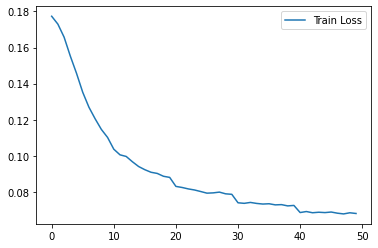

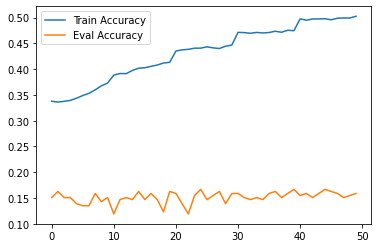

In [11]:
# 그래프로 loss 표기
#!pip install matplotlib
import matplotlib.pyplot as plt

plt.plot(list_train_loss, label='Train Loss')
#plt.plot(list_train_acc, label='Train Accuracy')
#plt.plot(list_validation_acc, label='Eval Accuracy')
plt.legend()
plt.show()

plt.plot(list_train_acc, label='Train Accuracy')
plt.plot(list_validation_acc, label='Eval Accuracy')
plt.legend()
plt.show()